# Scraping images from mapbox satelitar view  
Mapbox Free tier allows 50,000 requests per month : consider logging how many images have been scraped already to not exceed this limit.  


Pipeline : 
- Define area of interest (bounding box) from coordinates (lat, lon)
- Get the satelitar view of the bounding box from mapbox API
- Crop the images to remove watermark
- Save the images to disk
- Get the bounding boxes of buildings from OSM for the area of interest
- Save the bounding boxes to disk
- Clean overlapping bounding boxes (remove smaller ones or merge them)
- Save the cleaned bounding boxes to disk

The areas of interest have been picked manually :
- Top 20 most populous cities in France
- 100 rural areas coordinates picked randomly across France
- Maybe some random forest to get images without buildings (negative samples)

For the cities : 
- We define a bounding box around the city center with a fixed size (e.g., 10km x 10km)
- We then take random points from this bounding box to scrape images

Then, we can use the pipeline with these points to scrape images and get bounding boxes of buildings.

importing packages

In [ ]:
import os
import random
import requests
from pathlib import Path
from dotenv import load_dotenv

CONFIG

In [ ]:
# Load environment variables from .env file
load_dotenv()

# MAPBOX
MAPBOX_ACCESS_TOKEN = os.getenv("MAPBOX_ACCESS_TOKEN")

# Image parameters
NB_IMAGES = 2
WIDTH = 512
HEIGHT = 512 + 30  # extra space to then delete bottom part with watermark
ZOOM = 18  # 18-19 to see buildings, swimming pools clearly

BASE_DIR = Path().cwd() / "data"
RAW_DIR = BASE_DIR / "raw_images"
CROPPED_DIR = BASE_DIR / "cropped_images"

RAW_POLYGON_DIR = BASE_DIR / "raw_polygons"
CLEANED_POLYGON_DIR = BASE_DIR / "cleaned_polygons"


SETUP

In [ ]:
# ======================
# DOWNLOAD LOOP
# ======================
for i in range(NB_IMAGES):
    lat, lon = random_coord_france()

    url = (
        f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/"
        f"{lon},{lat},{ZOOM}/"
        f"{WIDTH}x{HEIGHT}"
        f"?access_token={MAPBOX_ACCESS_TOKEN}"
    )

    filename = os.path.join(OUTPUT_DIR, f"sat_{i:04d}.jpg")

    response = requests.get(url, timeout=30)

    if response.status_code == 200:
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"[OK] {filename}")
    else:
        print(f"[ERREUR] Image {i} - status {response.status_code}")



[OK] c:\Users\Prout\Documents\GitHub\SISE_satelitar_identifier\notebooks\data\scraped_images\sat_0000.jpg
[OK] c:\Users\Prout\Documents\GitHub\SISE_satelitar_identifier\notebooks\data\scraped_images\sat_0001.jpg


Trying on a city: Lyon

In [15]:
LYON_COORDS = (45.764043, 4.835659)

In [16]:
url = (
    f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/"
    f"{LYON_COORDS[1]},{LYON_COORDS[0]},{ZOOM}/"
    f"{WIDTH}x{HEIGHT}"
    f"?access_token={MAPBOX_ACCESS_TOKEN}"
)

filename = os.path.join(OUTPUT_DIR, f"sat_lyon.jpg")

response = requests.get(url, timeout=30)

if response.status_code == 200:
    with open(filename, "wb") as f:
        f.write(response.content)
    print(f"[OK] {filename}")
else:
    print(f"[ERREUR] Image {i} - status {response.status_code}")

[OK] c:\Users\Prout\Documents\GitHub\SISE_satelitar_identifier\notebooks\data\scraped_images\sat_lyon.jpg


Gif to show the improving of the bounding boxes cleaning process over time.

In [ ]:
import imageio
from PIL import Image, ImageDraw
from miscellaneous import clean_overlapping_bboxes, crop_image
# Function to create a GIF showing the cleaning process
image_path = "sat_lyon_tentative_gif.jpg"
width, height = 512, 512
frames = []

# Add the original image as the first frame
original_image = Image.open(image_path)

original_image = crop_image(
    image=original_image,
    top=0,
    left=0,
    right=width,
    bottom=height
)
frames.append(original_image.copy())

# Get the bounds of the geometries for coordinate transformation
minx, miny, maxx, maxy = gdf.total_bounds
IMG_SIZE = original_image.size[0]  # Assuming square image

def world_to_pixel(x, y):
    px = int((x - minx) / (maxx - minx) * IMG_SIZE)
    py = IMG_SIZE - int((y - miny) / (maxy - miny) * IMG_SIZE)
    return px, py

# Perform cleaning iteratively and save intermediate steps
for _ in range(1, 6):  # 5 iterations
    gdf = clean_overlapping_bboxes(
        gdf=gdf,
        what_to_do_on_overlap="merge"
    )

    # Draw the cleaned polygons on the image
    frame = original_image.copy()
    draw = ImageDraw.Draw(frame)

    for geom in gdf.geometry:
        if geom.geom_type == "Polygon":
            coords = geom.exterior.coords
        elif geom.geom_type == "MultiPolygon":
            coords = list(geom.geoms[0].exterior.coords)
        else:
            continue

        pixels = [world_to_pixel(x, y) for x, y in coords]
        draw.line(pixels, fill="red", width=2)

    frames.append(frame)

# Create the GIF
output_gif_path = "cleaning_process.gif"
imageio.mimsave(output_gif_path, frames, duration=0.5)



NameError: name 'gdf' is not defined

# CREATING A GIF

In [ ]:
from miscellaneous import create_bbox_from_coordinates, clean_overlapping_bboxes, ask_mapbox_for_image
import osmnx as ox

# Example usage
coords: tuple[float, float] = (45.76152575043509, 4.835588335610965)

image_path = "sat_lyon_tentative_gif.jpg"

# Generate bounding box for the given coordinates
bbox_for_mapbox: dict[str, float] = create_bbox_from_coordinates(
    coords[0],
    coords[1],
    img_height=512 + 30,  # extra space for watermark
    img_width=512,
    pixel_size=0.4
)
print(f"BBox for Mapbox: {bbox_for_mapbox}\n")


BBox for Mapbox: {'west': 4.8342388894606225, 'south': 45.760571310015, 'east': 4.836937828369254, 'north': 45.76248017476103}



Image saved to: sat_lyon_tentative_gif.jpg



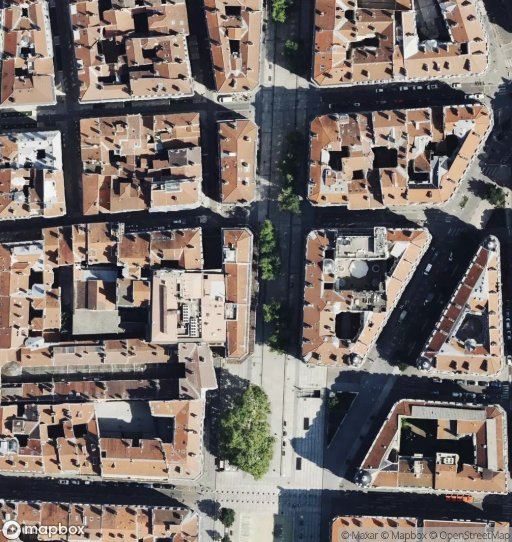

In [ ]:
# get the image from mapbox
# now we can use this bbox to download the image from mapbox static api
image = ask_mapbox_for_image(
    output_file=image_path,
    image_width_height={"width":512, "height":512+30},
    mapbox_token=MAPBOX_ACCESS_TOKEN,
    bounding_box=bbox_for_mapbox,
)
# parameters:
# - output_file: Path,
# - image_width_height: dict[str, int],
# - mapbox_token: str,
# - bounding_box: dict[str, float],
# - request_timeout: int = 10
print(f"Image saved to: {image_path}\n")    # displays the image
display(image)


In [ ]:
bbox_for_polygons: dict[str, float] = create_bbox_from_coordinates(
        coords[0],
        coords[1],
        img_height=512,
        img_width=512 # we removed the 30 pixels from the bottom for the watermark
    )
# Fetch polygons from OpenStreetMap for the bounding box
bbox_for_polygons = tuple(bbox_for_polygons.values())

gdf = ox.features_from_bbox(bbox=bbox_for_polygons, tags={"building": True})
gdf = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()

# Save raw polygons to file
raw_polygon_file = RAW_POLYGON_DIR / "buildings_example.geojson"
gdf.to_file(raw_polygon_file, driver="GeoJSON")
print(f"Raw polygons saved to: {raw_polygon_file}\n")


# Create GIF showing the cleaning process
output_gif_path = "cleaning_process.gif"
create_cleaning_gif(image_path, gdf, output_gif_path)
print(f"GIF saved to: {output_gif_path}")

Raw polygons saved to: c:\Users\olivi\Documents\GitHub\SISE_satelitar_identifier\data\raw_polygons\buildings_example.geojson

GIF saved to: cleaning_process.gif
